In [1]:
import pandas as pd
import numpy as np
import chromadb
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import os
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.question_answering import load_qa_chain
from langchain.output_parsers import CommaSeparatedListOutputParser
from semantic_router.layer import RouteLayer
from langchain.chains import ConversationChain
from langchain.prompts import PromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain.docstore.document import Document
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_text_splitters import CharacterTextSplitter
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity

#BERTscore
#import bert_score
import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)
#from bert_score import BERTScorer
from BRAD import brad
from BRAD import rag

/force RAG summarize the human transcription factors paper

find me papers about transcription factors on biorxiv

NVIDIA KEY
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

## Single Document Calling

In [1]:
from BRAD import brad
brad.chat()

Welcome to RAG! The chat log from this conversation will be saved to /home/machoi/BRAD/2024-06-28_16-16-57/log.json. How can I help?


Enter your NVIDIA API key:  ········



Would you like to use a database with BRAD [Y/N]?


 N


2024-06-28 16:17:44 INFO semantic_router.utils.logger local


Input >>  find me papers about transcription factors on biorxiv


RAG >> 1: 

> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation:

    
    Query:find me papers about transcription factors on biorxiv
    
    From the query, decide if ARXIV, PUBMED, or BIORXIV should be searched, and propose no more than 10 search terms for this query and database. Separate each term with a comma, and provide no extra information/explination for either the database or search terms. Format your output as follows with no additions:
    
    Database: <ARXIV, PUBMED, or BIORXIV>
    Search Terms: <improved search terms>
    

> Finished chain.
searching on BIORXIV...
Search Terms: ['transcription factor', 'transcriptional regulation', 'gene expression', 'regulatory elements', 'gene regulatory networks', 'chromatin immunoprecipitation', 'ChIP-seq', 'DNA-binding proteins', 'regulatory motifs', 'transcriptional activators']
transcription factor
what is this: intermediate_string
abstract_title%3Atranscription%2Bfactor
http://biorxiv.org/

Input >>  quit


Thanks for chatting today! I hope to talk soon, and don't forget that a record of this conversation is available at: /home/machoi/BRAD/2024-06-28_16-16-57/log.json


In [ ]:
#experimental - see the relative frequency of periods showing up in a given doc
def relative_frequency_of_dot(input_string):
    if not input_string:
        return 0.0  # Return 0 if the string is empty
    
    dot_count = input_string.count('.')
    total_characters = len(input_string)
    
    relative_frequency = dot_count / total_characters
    
    return relative_frequency

def cut(chatstatus, vectordb, path):
    metadata_full = vectordb.get()['metadatas']
    source_list = [item['source'] for item in metadata_full]   
    real_source_list = [((item.replace(path, '')).removesuffix('.pdf')).lower() for item in source_list]
    df = pd.DataFrame({'id' :vectordb.get()['ids'] , 'documents' : vectordb.get()['documents'], 'metadatas' : real_source_list})
    relfreq = []
    for docs in df['documents']:
        relfreq.append(relative_frequency_of_dot(docs))
    df['relfreq'] = relfreq
    #determine this more scientifically?
    filtered_df = df[df['relfreq'] < 0.03]
    filtered_ids = filtered_df['id'].to_list()
    embeddings_model = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')
    db_name = "no_bib_DB_cosine_cSize_%d_cOver_%d" % (700, 200)
    #Get IDs
    text = vectordb.get(ids=filtered_ids)['documents']
    new_path = chatstatus['output-directory']+'/no_bib'
    newdb = Chroma(persist_directory=new_path, embedding_function=embeddings_model, collection_name=db_name)
    newdb.add_texts(text)
    return newdb


def get_all_sources(vectordb, prompt, path):
    prompt = prompt.lower()
    metadata_full = vectordb.get()['metadatas']
    source_list = [item['source'] for item in metadata_full]   
    real_source_list = [((item.replace(path, '')).removesuffix('.pdf')).lower() for item in source_list]
    db = pd.DataFrame({'id' :vectordb.get()['ids'] , 'metadatas' : real_source_list})
    filtered_df = db[db['metadatas'].apply(lambda x: x in prompt)]
    return real_source_list, filtered_df['id'].to_list()

def restrictedDB(chatstatus, vectordb, path):
    prompt = chatstatus['prompt']
    #path = "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/"
    embeddings_model = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')
    db_name = "new_DB_cosine_cSize_%d_cOver_%d" % (700, 200)
    title_list, real_id_list = get_all_sources(vectordb, prompt, path)
    best_title, best_score = best_match(prompt, title_list)
    title_list, real_id_list = get_all_sources(vectordb, best_title, path)
    text = vectordb.get(ids=real_id_list)['documents']
    #maybe make this a new path argument idk
    new_path = chatstatus['output-directory']+'/restricted'
    newdb = Chroma(persist_directory=new_path, embedding_function=embeddings_model, collection_name=db_name)
    newdb.add_texts(text)
    return best_score, newdb
    

In [6]:
path = '/nfs/turbo/umms-indikar/shared/projects/RAG/databases/EXP2/'
vectordb, embeddings_model = brad.load_literature_db(persist_directory='/nfs/turbo/umms-indikar/shared/projects/RAG/databases/EXP2/')

                                        id  \
0     0003eff7-c988-466f-97bd-85df69ca723a   
1     00051c4b-22c7-4a78-9228-3c0c80f49a9f   
2     001051b3-d967-40be-bf97-15f77c4b7935   
3     001b09f1-1682-4f8c-a7fe-54794dcac1c8   
4     002de69a-4c66-43a5-a4d0-b5c9198a8ce2   
...                                    ...   
9048  ffd8cc74-9ea9-4fee-971b-97486acf6096   
9049  ffe27b33-a933-4e8d-95e3-c7ce766228f9   
9050  ffe53d46-116f-4915-8f42-280cd4c683b5   
9051  ffeb3f47-dd9b-4403-9df6-a12b3e44d928   
9052  ffebb0c6-3c5f-4342-a663-2a96e4b010db   

                                              documents  \
0     lOE(A)\nFIG.1.MapsoftheparentandMyoDretrovirus...   
1     virally deliv-\nering Ascl1 to Mu ¨ller glia i...   
2     assign a p value to the whole-chromosome score...   
3     stage of differentiation, \nwhen the globin ge...   
4     set of devices for ﬂow barcoding a tissue slid...   
...                                                 ...   
9048  proliferating card-\niac fib

/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


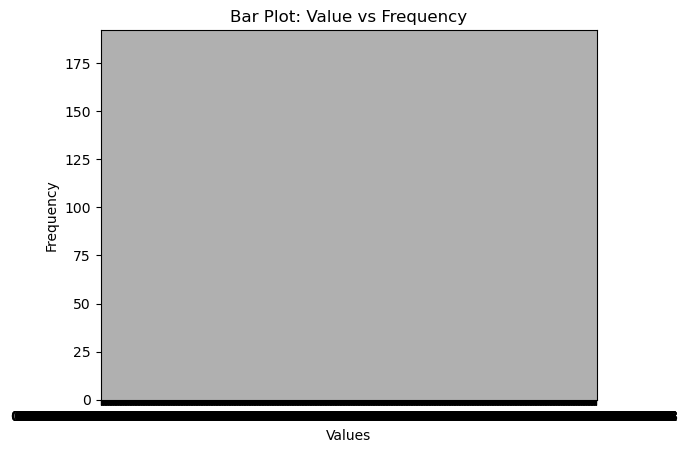

In [15]:
path = "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/"
metadata_full = vectordb.get()['metadatas']
source_list = [item['source'] for item in metadata_full]   
real_source_list = [((item.replace(path, '')).removesuffix('.pdf')).lower() for item in source_list]
df = pd.DataFrame({'id' :vectordb.get()['ids'] , 'documents' : vectordb.get()['documents'], 'metadatas' : real_source_list})
relfreq = []
for docs in df['documents']:
    relfreq.append(relative_frequency_of_dot(docs))
#print(relfreq)
df['relfreq'] = relfreq
print(df)


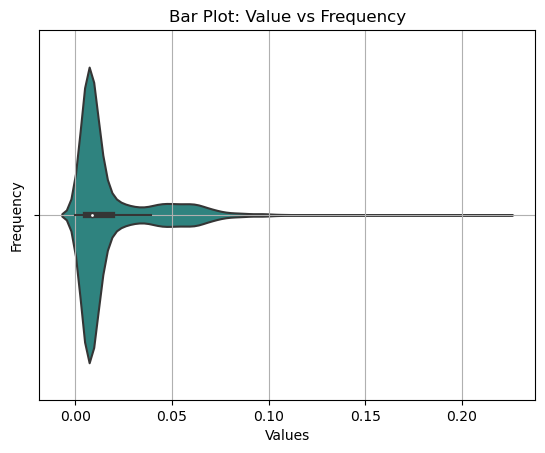

In [16]:
sns.violinplot(x=relfreq, palette='viridis')
plt.title('Bar Plot: Value vs Frequency')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [25]:
filtered_df = df[df['relfreq'] < 0.03]
filtered_df
#len(filtered_df)
#df.iloc[9047 	]['documents']

7251

In [ ]:
def restrictedDB(chatstatus, vectordb, path):
    prompt = chatstatus['prompt']
    #path = "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/"
    embeddings_model = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')
    db_name = "new_DB_cosine_cSize_%d_cOver_%d" % (700, 200)
    title_list, real_id_list = get_all_sources(vectordb, prompt, path)
    best_title, best_score = best_match(prompt, title_list)
    title_list, real_id_list = get_all_sources(vectordb, best_title, path)
    text = vectordb.get(ids=real_id_list)['documents']
    #maybe make this a new path argument idk
    new_path = chatstatus['output-directory']+'/restricted'
    newdb = Chroma(persist_directory=new_path, embedding_function=embeddings_model, collection_name=db_name)
    newdb.add_texts(text)
    return best_score, newdb

In [3]:
help(vectordb)

Help on Chroma in module langchain_chroma.vectorstores object:

class Chroma(langchain_core.vectorstores.VectorStore)
 |  Chroma(collection_name: 'str' = 'langchain', embedding_function: 'Optional[Embeddings]' = None, persist_directory: 'Optional[str]' = None, client_settings: 'Optional[chromadb.config.Settings]' = None, collection_metadata: 'Optional[Dict]' = None, client: 'Optional[chromadb.ClientAPI]' = None, relevance_score_fn: 'Optional[Callable[[float], float]]' = None, create_collection_if_not_exists: 'Optional[bool]' = True) -> 'None'
 |  
 |  `ChromaDB` vector store.
 |  
 |  To use, you should have the ``chromadb`` python package installed.
 |  
 |  Example:
 |      .. code-block:: python
 |  
 |              from langchain_chroma import Chroma
 |              from langchain_openai import OpenAIEmbeddings
 |  
 |              embeddings = OpenAIEmbeddings()
 |              vectorstore = Chroma("langchain_store", embeddings)
 |  
 |  Method resolution order:
 |      Chroma
 | 

In [4]:
test_list = list(vectordb.get()['ids'][:10])

In [5]:
source_title = []
path = "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/"
print(path)
for metadata in vectordb.get()['metadatas']:
    source_title.append(metadata['source'].removeprefix(path).removesuffix(".pdf"))
no_repeat_source_title = set(source_title)
post_process_title = [x.lower() for x in no_repeat_source_title]
print(post_process_title)

/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/
['a transient disruption of fibroblastic', 'szklarczyk2023string', 'in vivo cellular reprogramming the next generation', 'direct cell reprogramming', 'ismara automated modeling of genomic signals as a democracy of regulatory motifs', 'similar active genes cluster in specialized transcription factories', 'cooperative transcription factor induction', 'updated perspectives on direct vascular cellular reprogramming', 'elite and stochastic models for induced pluripotent stem cell generation', 'transcription factors orchestrate dynamic interplay between genome topology and gene regulation during cell reprogramming', 'the circuitry of a master switch', 'a comprehensive library of human transcription factors for cell fate engineering', 'qiu et al. - 2022 - mapping transcriptomic vector fields of single cel', 'ahmad and henikoff - 2021 - the h3.3k27m oncohistone antagonizes reprogramming', 'conserved transcription factors promote cell fat

In [6]:
#Split into two methods?
def get_all_sources(prompt, path):
    prompt = prompt.lower()
    metadata_full = vectordb.get()['metadatas']
    source_list = [item['source'] for item in metadata_full]   
    real_source_list = [((item.replace(path, '')).removesuffix('.pdf')).lower() for item in source_list]
    db = pd.DataFrame({'id' :vectordb.get()['ids'] , 'metadatas' : real_source_list})
    filtered_df = db[db['metadatas'].apply(lambda x: x in prompt)]
    return real_source_list, filtered_df['id'].to_list()
        

In [7]:
prompt = 'Summarize the human transcription factors paper'
path = "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/"
embeddings_model = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')
db_name = "new_DB_cosine_cSize_%d_cOver_%d" % (700, 200)
title_list, real_id_list = get_all_sources(prompt, path)
best_title, best_score = best_match(prompt, title_list)
title_list, real_id_list = get_all_sources(best_title, path)
text = vectordb.get(ids=real_id_list)['documents']
print(len(text))
#newdb = Chroma(persist_directory='/nfs/turbo/umms-indikar/shared/projects/RAG/databases/new_EXP3/', embedding_function=embeddings_model, collection_name=db_name)
#print(len(newdb.get()['documents']))
#newdb.add_texts(text)
#print(len(newdb.get()['documents']))

#things to do - hook this up with RAG (shouldnt be too bad)
#determine how to sift thru the prompt or go thru paper titles that are not well done
#ask about which paper db to use on turbo
#where to save this new db
#sometimes there is a weird error that occurs - maybe split up lower text stuff but idk how that effects runtime
#how to remove docs from database / make new one everytime since it keeps adding to it

Wed Jun 19 09:35:12 2024 INFO Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5
Wed Jun 19 09:35:14 2024 INFO Use pytorch device_name: cpu


NameError: name 'best_match' is not defined

In [ ]:
from sentence_transformers import SentenceTransformer, util


#Given the prompt, find the title and corresponding score that is the best match
def best_match(prompt, title_list):
    sentence_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
    unique_title_list = list(set(title_list))
    query_embedding = sentence_model.encode(prompt)
    passage_embedding = sentence_model.encode(unique_title_list)

    save_title = ""
    save_score = 0

    for score, title in zip(util.cos_sim(query_embedding, passage_embedding)[0], unique_title_list):
        if score > save_score:
            save_score = score
            save_title = title
    print(f"The best match is {save_title} with a score of {save_score}")
    return save_title, save_score

In [ ]:
save_title

In [ ]:
sentence_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
unique_title_list = list(set(title_list))
query_embedding = sentence_model.encode(prompt)
passage_embedding = sentence_model.encode(unique_title_list)

save_title = ""
save_score = 0

for score, title in zip(util.cos_sim(query_embedding, passage_embedding)[0], unique_title_list):
    if score > save_score:
        save_score = score
        save_title = title
print(f"The best match is {save_title} with a score of {save_score}")

In [ ]:
title_list, real_id_list = get_all_sources(save_title, "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/")
text = vectordb.get(ids=real_id_list)['documents']
#print(text)

In [ ]:


def restrictedDB(prompt, vectordb, path):
    #path = "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/"
    embeddings_model = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')
    db_name = "new_DB_cosine_cSize_%d_cOver_%d" % (700, 200)
    title_list, real_id_list = get_all_sources(prompt, path)
    best_title, best_score = best_match(prompt, title_list)
    title_list, real_id_list = get_all_sources(best_title, path)
    text = vectordb.get(ids=real_id_list)['documents']
    newdb = Chroma(persist_directory='/nfs/turbo/umms-indikar/shared/projects/RAG/databases/new_EXP3/', embedding_function=embeddings_model, collection_name=db_name)
    newdb.add_texts(text)
    return best_score, newdb


#Given the prompt, find the title and corresponding score that is the best match
def best_match(prompt, title_list):
    sentence_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
    unique_title_list = list(set(title_list))
    query_embedding = sentence_model.encode(prompt)
    passage_embedding = sentence_model.encode(unique_title_list)

    save_title = ""
    #adjust the save_score to be the threshold cutoff - set to 0.75 but maybe thats too high
    save_score = 0.75

    for score, title in zip(util.cos_sim(query_embedding, passage_embedding)[0], unique_title_list):
        if score > save_score:
            save_score = score
            save_title = title
    print(f"The best match is {save_title} with a score of {save_score}")
    return save_title, save_score

#Split into two methods?
def get_all_sources(prompt, path):
    prompt = prompt.lower()
    metadata_full = vectordb.get()['metadatas']
    source_list = [item['source'] for item in metadata_full]   
    real_source_list = [((item.replace(path, '')).removesuffix('.pdf')).lower() for item in source_list]
    db = pd.DataFrame({'id' :vectordb.get()['ids'] , 'metadatas' : real_source_list})
    filtered_df = db[db['metadatas'].apply(lambda x: x in prompt)]
    return real_source_list, filtered_df['id'].to_list()

In [ ]:
prompt = 'Summarize the human transcription factors paper'
path = "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/"
#path = '/nfs/turbo/umms-indikar/shared/projects/RAG/databases/EXP2/'
vectordb, embeddings_model = brad.load_literature_db(persist_directory='/nfs/turbo/umms-indikar/shared/projects/RAG/databases/EXP2/')
best_score, text = restrictedDB(prompt, vectordb, path)
print(best_score)

## PageRanker 

In [ ]:
def remove_repeats(vectordb):
    df = pd.DataFrame({'id' :vectordb.get()['ids'] , 'documents' : vectordb.get()['documents']})
    repeated_ids = df[df.duplicated(subset='documents', keep='last')]['id'].tolist()
    vectordb.delete(repeated_ids)
    return vectordb

In [ ]:
remove_repeats(vectordb)

In [ ]:
#vectordb.get()['documents']

In [23]:
#Given the prompt, find the title and corresponding score that is the best match
def adj_matrix_builder(vectordb):
    dimension = len(vectordb.get()['documents'])
    adj_matrix = np.zeros([dimension, dimension])
    
    sentence_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
    passage_embedding = sentence_model.encode(vectordb.get()['documents'])
    cosine_similarities = cosine_similarity(passage_embedding[0:10])
    print(cosine_similarities)
    return cosine_similarities

# Normalize columns of A
def normalize_adjacency_matrix(A):
    col_sums = A.sum(axis=0)
    return A / col_sums[np.newaxis, :]

#weighted pagerank algorithm
def pagerank_weighted(A, alpha=0.85, tol=1e-6, max_iter=100):
    n = A.shape[0]
    A_normalized = normalize_adjacency_matrix(A)
    v = np.ones(n) / n  # Initial PageRank vector

    for _ in range(max_iter):
        v_next = alpha * A_normalized.dot(v) + (1 - alpha) / n
        if np.linalg.norm(v_next - v, 1) < tol:
            break
        v = v_next

    return v

#reranker

def pagerank_rerank(vectordb):
    adj_matrix = adj_matrix_builder(vectordb)
    pagerank_scores = pagerank_weighted(A = adj_matrix)
    top_rank_scores = sorted(range(len(pagerank_scores)), key=lambda i: pagerank_scores[i], reverse=True)[1:11]
    df = pd.DataFrame({'id' :vectordb.get()['ids'] , 'documents' : vectordb.get()['documents'], 'metadatas' : vectordb.get()['metadatas']})
    reranked_df = df.iloc[top_rank_scores]
    return reranked_df

In [ ]:
#rank_scores = pagerank_rerank(vectordb)
#print(rank_scores)


In [ ]:
#first entry is always the prompt



In [10]:
#Given the prompt, find the title and corresponding score that is the best match
def adj_matrix_builder(vectordb):
    dimension = len(vectordb.get()['documents'])
    adj_matrix = np.zeros([dimension, dimension])
    
    sentence_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
    passage_embedding = sentence_model.encode(vectordb.get()['documents'])
    print(type(passage_embedding))
    print(passage_embedding)
    pos = 1
    for score in zip(util.cos_sim(query_embedding, passage_embedding)[0]):
        adj_matrix[0][pos] = score[0]
        adj_matrix[pos][0] = score[0]
        pos += 1
    return adj_matrix

# Normalize columns of A
def normalize_adjacency_matrix(A):
    col_sums = A.sum(axis=0)
    return A / col_sums[np.newaxis, :]

#weighted pagerank algorithm
def pagerank_weighted(A, alpha=0.85, tol=1e-6, max_iter=100):
    n = A.shape[0]
    A_normalized = normalize_adjacency_matrix(A)
    v = np.ones(n) / n  # Initial PageRank vector

    for _ in range(max_iter):
        v_next = alpha * A_normalized.dot(v) + (1 - alpha) / n
        if np.linalg.norm(v_next - v, 1) < tol:
            break
        v = v_next

    return v

#reranker

def pagerank_rerank(prompt, vectordb):
    adj_matrix = adj_matrix_builder(prompt, vectordb)
    pagerank_scores = pagerank_weighted(A = adj_matrix)
    top_rank_scores = sorted(range(len(pagerank_scores)), key=lambda i: pagerank_scores[i], reverse=True)[1:11]
    df = pd.DataFrame({'id' :vectordb.get()['ids'] , 'documents' : vectordb.get()['documents'], 'metadatas' : vectordb.get()['metadatas']})
    reranked_df = df.iloc[top_rank_scores]
    return reranked_df

In [ ]:
#I THINK THIS FRAMEWORK WORKS BETTER


#Given the prompt, find the title and corresponding score that is the best match
def adj_matrix_builder(docs, scores):
    dimension = len(docs)
    adj_matrix = np.zeros([dimension, dimension])
    pos = 1
    for score in scores:
        adj_matrix[0][pos] = score
        adj_matrix[pos][0] = score
        pos += 1
    return adj_matrix

# Normalize columns of A
def normalize_adjacency_matrix(A):
    col_sums = A.sum(axis=0)
    return A / col_sums[np.newaxis, :]

#weighted pagerank algorithm
def pagerank_weighted(A, alpha=0.85, tol=1e-6, max_iter=100):
    n = A.shape[0]
    A_normalized = normalize_adjacency_matrix(A)
    v = np.ones(n) / n  # Initial PageRank vector

    for _ in range(max_iter):
        v_next = alpha * A_normalized.dot(v) + (1 - alpha) / n
        if np.linalg.norm(v_next - v, 1) < tol:
            break
        v = v_next

    return v

#reranker

def pagerank_rerank(docs, scores):
    adj_matrix = adj_matrix_builder(docs, scores)
    pagerank_scores = pagerank_weighted(A = adj_matrix)
    top_rank_scores = sorted(range(len(pagerank_scores)), key=lambda i: pagerank_scores[i], reverse=True)[1:11]
    reranked_docs = [docs[i] for i in top_rank_scores]
    return reranked_docs

In [2]:
path = "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/EXP2/"
metadata_full = vectordb.get()['metadatas']
source_list = [item['source'] for item in metadata_full]   
real_source_list = [((item.replace(path, '')).removesuffix('.pdf')).lower() for item in source_list]
df = pd.DataFrame({'id' :vectordb.get()['ids'] , 'documents' : vectordb.get()['documents'], 'metadatas' : real_source_list})
df

NameError: name 'vectordb' is not defined

In [ ]:
brad.chat()

Pairwise Cosine Similarities:
[[1.         0.97463185 0.95941195]
 [0.97463185 1.         0.99819089]
 [0.95941195 0.99819089 1.        ]]


In [3]:
brad.chat()

NameError: name 'brad' is not defined